<a href="https://colab.research.google.com/github/BearKS/Robotic-weed-control-system/blob/feature%2Fsegmentation/Weed_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

In [1]:
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [3]:
#segmentation model lib
!pip install albumentations>=0.3.0 
!pip install --pre segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Loading dataset

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras

In [ ]:
!unzip /content/drive/MyDrive/Project/predataset2.zip

Archive:  /content/drive/MyDrive/Project/predataset2.zip
   creating: predataset/test/
   creating: predataset/test/images/
  inflating: predataset/test/images/T02_Box007_2017-09-09T08-52-40-045.png  
  inflating: predataset/test/images/T02_Box007_2017-09-10T05-55-35-248.png  
  inflating: predataset/test/images/T02_Box007_2017-09-11T10-38-11-116.png  
  inflating: predataset/test/images/T02_Box007_2017-09-28T10-42-55-040.png  
  inflating: predataset/test/images/T02_Box007_2017-09-29T11-27-55-959.png  
  inflating: predataset/test/images/T02_Box007_2017-10-04T10-15-38-256.png  
  inflating: predataset/test/images/T02_Box007_2017-10-06T13-40-15-271.png  
  inflating: predataset/test/images/T02_Box007_2017-10-15T05-42-26-641.png  
  inflating: predataset/test/images/T02_Box029_2017-09-12T08-51-39-191.png  
  inflating: predataset/test/images/T02_Box029_2017-09-14T08-35-48-889.png  
  inflating: predataset/test/images/T02_Box029_2017-09-17T11-28-36-738.png  
  inflating: predataset/test/

In [5]:
DATA_DIR = 'predataset/'

In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [7]:
w = 128
h = 128

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['plant']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

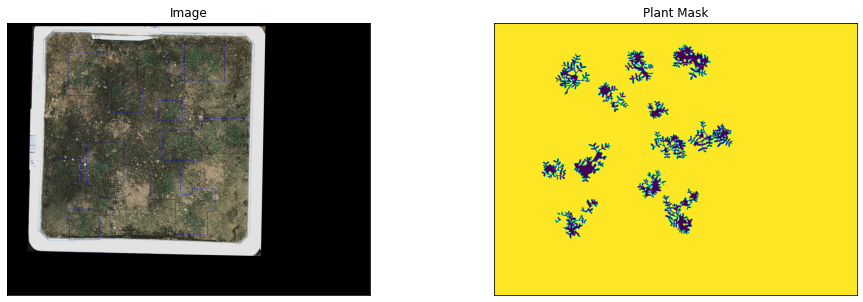

In [9]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['plant'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    plant_mask=mask[..., 0].squeeze(),
    # sky_mask=mask[..., 1].squeeze(),
    # background_mask=mask[..., 2].squeeze(),
)

##Augmentations

In [10]:
import albumentations as A

In [31]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=h, min_width=w, always_apply=True, border_mode=0),
        # A.RandomCrop(height=h, width=w, always_apply=True),
        A.CropNonEmptyMaskIfExists(height=h, width=w, always_apply=True,p = 1.0),

        A.GaussNoise (p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        # A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(h, w)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


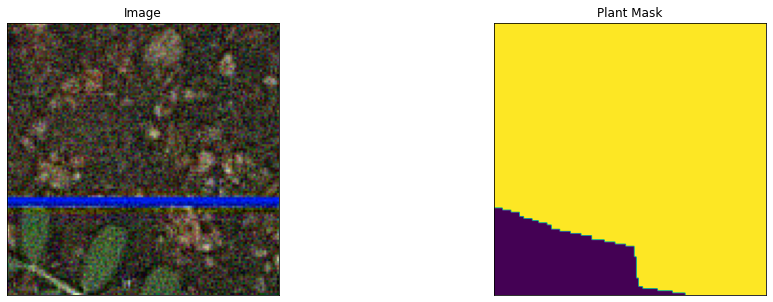

In [32]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['plant'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    plant_mask=mask[..., 0].squeeze(),
    # sky_mask=mask[..., 1].squeeze(),
    # background_mask=mask[..., 2].squeeze(),
)

##Segmentation model training

In [13]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


'tf.keras'

In [14]:
BACKBONE = 'vgg16'
BATCH_SIZE = 8
CLASSES = ['plant']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [73]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [74]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [49]:
def create_model(lrn_rate,optimizer='Adam'):
  n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
  activation = 'sigmoid' if n_classes == 1 else 'softmax'

  #create model
  model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
  if optimizer=="Adam":
    opt = tf.keras.optimizers.Adam(lrn_rate)
  elif optimizer=="SGD":
    opt = keras.optimizers.SGD(learning_rate=lrn_rate)
  else :
    opt = keras.optimizers.Adadelta(learning_rate=lrn_rate) # need some default 
  # optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)

  # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
  # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # compile keras model with defined optimozer, loss and metrics
  model.compile(opt, total_loss, metrics)

  return model;


In [50]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=create_model)

<ipython-input-50-d40190eb9f4a>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)


In [75]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, h, w, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, h, w, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    # keras.callbacks.ModelCheckpoint('./model_v5_1024.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ModelCheckpoint('./model_v10_128.h5', save_weights_only=False, save_best_only=True, mode='max',monitor='val_iou_score'),
    # keras.callbacks.ModelCheckpoint('./model_v7_128.h5', save_weights_only=False, save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(),
]

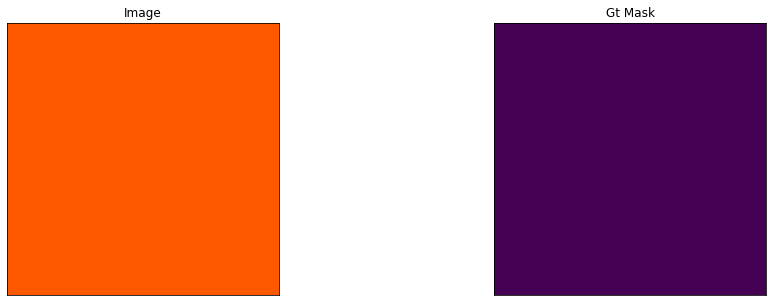

In [76]:
for i in range(1):
    
    image, gt_mask = train_dataset[i]
    image = np.expand_dims(image, axis=0)
    # pr_mask = model.predict(image).round()
    
    # im = Image.fromarray(pr_mask)
    # im.save(f'{i}.png')
 
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        # pr_mask=pr_mask[..., 0].squeeze(),
    )

In [53]:
x_train = []
y_train = []
for x,y in train_dataset:
  x_train.append(x)
  y_train.append(y)
  # print(x.shape,y.shape)

In [54]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [55]:
print(x_train.shape)

(100, 128, 128, 3)


In [18]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
12/12 [==============================] - 176s 15s/step - loss: 0.4488 - iou_score: 0.4476 - f1-score: 0.6149 - val_loss: 0.9492 - val_iou_score: 0.0420 - val_f1-score: 0.0806 - lr: 1.0000e-04
Epoch 2/40
12/12 [==============================] - 123s 11s/step - loss: 0.4133 - iou_score: 0.5381 - f1-score: 0.6958 - val_loss: 1.0978 - val_iou_score: 0.0372 - val_f1-score: 0.0717 - lr: 1.0000e-04
Epoch 3/40
12/12 [==============================] - 123s 11s/step - loss: 0.4087 - iou_score: 0.5036 - f1-score: 0.6651 - val_loss: 0.9416 - val_iou_score: 0.0496 - val_f1-score: 0.0944 - lr: 1.0000e-04
Epoch 4/40
12/12 [==============================] - 123s 11s/step - loss: 0.3711 - iou_score: 0.6005 - f1-score: 0.7473 - val_loss: 0.8561 - val_iou_score: 0.1708 - val_f1-score: 0.2908 - lr: 1.0000e-04
Epoch 5/40
12/12 [==============================] - 123s 11s/step - loss: 0.3984 - iou_score: 0.5513 - f1-score: 0.6994 - val_loss: 0.6575 - val_iou_score: 0.2648 - val_f1-score: 0.4159 - 

In [19]:
model.save('./model_v8_128.h5')

In [77]:
# train model 1024
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
12/12 [==============================] - 149s 13s/step - loss: 0.6958 - iou_score: 0.0592 - f1-score: 0.1117 - val_loss: 1.0076 - val_iou_score: 0.1000 - val_f1-score: 0.1817 - lr: 1.0000e-04
Epoch 2/40
12/12 [==============================] - 145s 13s/step - loss: 0.6509 - iou_score: 0.0717 - f1-score: 0.1332 - val_loss: 0.6206 - val_iou_score: 0.6100 - val_f1-score: 0.7575 - lr: 1.0000e-04
Epoch 3/40
12/12 [==============================] - 145s 13s/step - loss: 0.6048 - iou_score: 0.1126 - f1-score: 0.2014 - val_loss: 0.5768 - val_iou_score: 0.1846 - val_f1-score: 0.3112 - lr: 1.0000e-04
Epoch 4/40
12/12 [==============================] - 145s 12s/step - loss: 0.5655 - iou_score: 0.2072 - f1-score: 0.3286 - val_loss: 0.6746 - val_iou_score: 0.1887 - val_f1-score: 0.3171 - lr: 1.0000e-04
Epoch 5/40
12/12 [==============================] - 145s 12s/step - loss: 0.5209 - iou_score: 0.2693 - f1-score: 0.4066 - val_loss: 0.7351 - val_iou_score: 0.1705 - val_f1-score: 0.2912 - 

### Hyperparameter tunning

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from mpl_toolkits import mplot3d
from sklearn import metrics
import glob
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [57]:
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
epochs = [40,60,80]
batch_size = [2,4,8]
learning_rate = [0.0001,0.001,0.01]

In [58]:
def PlotBar(ax,type_search,mean, params):
  columns_list = ['Batch_Epoch','SGD','RMSprop','Adadelta','Adam']
  opt_score = [['B8E2',0,0,0,0],['B8E4',0,0,0,0],['B8E6',0,0,0,0],['B16E2',0,0,0,0],
               ['B16E4',0,0,0,0],['B16E6',0,0,0,0],['B32E2',0,0,0,0],['B32E4',0,0,0,0],
               ['B32E6',0,0,0,0]]
  if (type_search == 'Grid Search'): 
    for index in range(len(params)):
      if params[index]['batch_size'] == 2 and params[index]['epochs'] == 20:
        opt_score[0] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[0])
      elif params[index]['batch_size'] == 2 and params[index]['epochs'] == 30:
        opt_score[1] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[1])
      elif params[index]['batch_size'] == 2 and params[index]['epochs'] == 40:
        opt_score[2] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[2])
      elif params[index]['batch_size'] == 4 and params[index]['epochs'] == 20:
        opt_score[3] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[3])
      elif params[index]['batch_size'] == 4 and params[index]['epochs'] == 30:
        opt_score[4] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[4])
      elif params[index]['batch_size'] == 4 and params[index]['epochs'] == 40:
        opt_score[5] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[5])
      elif params[index]['batch_size'] == 8 and params[index]['epochs'] == 20:
        opt_score[6] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[6])
      elif params[index]['batch_size'] == 8 and params[index]['epochs'] == 30:
        opt_score[7] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[7])
      elif params[index]['batch_size'] == 8 and params[index]['epochs'] == 40:
        opt_score[8] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[8])

    df = pd.DataFrame(opt_score,columns = columns_list)
    df.plot(ax=ax,x='Batch_Epoch',
      kind='bar',
      stacked=False,
      title=type_search)

  else :
    # Define data values
    b_e_list =[]
    x_axis = []
    batch_epoch = []
    op1, op2, op3, op4 = [],[],[],[]
    for index in range(len(params)):
      b_e = [params[index]['batch_size'],params[index]['epochs']]
      if b_e not in b_e_list:
        b_e_list.append(b_e)
        batch_epoch.append("B"+str(b_e[0])+"E"+str(b_e[1]))
        x_axis.append(index)
        op1.append(0)
        op2.append(0)
        op3.append(0)
        op4.append(0)
      for i in range(len(b_e_list)):
        if b_e == b_e_list[i]:
          if params[index]['optimizer'] == 'SGD':
            op1[i] = mean[index]
          elif params[index]['optimizer'] == 'RMSprop':
            op2[i] = mean[index]
          elif params[index]['optimizer'] == 'Adadelta':
            op3[i] = mean[index]
          elif params[index]['optimizer'] == 'Adam':
            op4[i] = mean[index]
    # Plot a simple line chart
    ax.plot(x_axis, op1, 'g', label='SGD')
    ax.plot(x_axis, op2, 'r', label='RMSprop')
    ax.plot(x_axis, op3, 'y', label='Adadelta')
    ax.plot(x_axis, op4, 'b', label='Adam')
    ax.title.set_text(type_search)

    plt.xticks(x_axis,batch_epoch)
    plt.legend()

In [59]:
def MapOptimizer(val, opt, bactch_ep):
  if opt == 'SGD' :
    bactch_ep[1] = val
  elif opt == 'RMSprop' :
    bactch_ep[2] = val
  elif opt == 'Adadelta' :
    bactch_ep[3] = val
  elif opt == 'Adam' :
    bactch_ep[4] = val
    
  return bactch_ep

In [60]:
# plt.imshow(train_dataset.__getitem__(20)[0])
# 6.3 (a) Create GridSearchCV()
# กำหนด Grid Search parameters -> param_grid
import joblib 

#define the grid search parameters 
param_grid = dict(batch_size = batch_size, epochs=epochs,lrn_rate=learning_rate)
# param_grid = dict(batch_size=batch_size, epochs=epochs,optimizer=optimizer,lrn_rate=learning_rate)
# param_grid = dict( epochs=epochs,optimizer=optimizer,lrn_rate=learning_rate)
#Grid Search Parameter: 4 x 3 x 3 = 36 combinations

#Declare -> GridSearchCV()
#run grid.fit() -> เก็บ accuracy ของ Cross validation (cv = 2)
grid = GridSearchCV(estimator=model, n_jobs = 1, verbose= 0,cv=2, param_grid = param_grid, refit=True)
print(x_train_dir,y_train_dir)
grid_result = grid.fit(x_train,y_train)

# estimator = grid_result.best_estimator_
# estimator.model.save('my_model.h5')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)


# Display Statistics view
# Error results from All combinations of grid parameters 
# -> plot() หรือ bar()
# fig, (ax1, ax2) = plt.subplots(2, figsize=(20,10))
# PlotBar(ax1,'Grid Search',means, params)
# # PlotBar(ax2,'Random Search',means_2, params_2)
# plt.tight_layout()
# plt.show()

Streaming output truncated to the last 5000 lines.
Epoch 42/80
25/25 [==============================] - 1s 38ms/step - loss: 0.1357 - iou_score: 0.9474 - f1-score: 0.9683
Epoch 43/80
25/25 [==============================] - 1s 39ms/step - loss: 0.1715 - iou_score: 0.9474 - f1-score: 0.9600
Epoch 44/80
25/25 [==============================] - 1s 38ms/step - loss: 0.1584 - iou_score: 0.9474 - f1-score: 0.9683
Epoch 45/80
25/25 [==============================] - 1s 38ms/step - loss: 0.1407 - iou_score: 0.9474 - f1-score: 0.9656
Epoch 46/80
25/25 [==============================] - 1s 38ms/step - loss: 0.1319 - iou_score: 0.9474 - f1-score: 0.9683
Epoch 47/80
25/25 [==============================] - 1s 39ms/step - loss: 0.1296 - iou_score: 0.9474 - f1-score: 0.9680
Epoch 48/80
25/25 [==============================] - 1s 38ms/step - loss: 0.1612 - iou_score: 0.9474 - f1-score: 0.9683
Epoch 49/80
25/25 [==============================] - 1s 38ms/step - loss: 0.1428 - iou_score: 0.9474 - f1-sco

In [ ]:
new_model.summary

{'batch_size': 8, 'epochs': 30, 'lrn_rate': 0.1}

In [ ]:
from keras.models import load_model
def loss_fn():
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)
  return total_loss
def IOUScore():
  return sm.metrics.IOUScore(threshold=0.5)
def f1_fn():
  return sm.metrics.FScore(threshold=0.5)
# Instantiate the model as you please (we are not going to use this)
new_model = KerasRegressor(build_fn=create_model)
# model2 = KerasRegressor(build_fn=model_build_fn, epochs=10, batch_size=10, verbose=1)
new_model.model = load_model('my_model.h5',custom_objects={'dice_loss_plus_1binary_focal_loss':loss_fn,'iou_score':IOUScore,'f1-score':f1_fn})
new_model.model.summary()

Model: "model_607"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_608 (InputLayer)         [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_608[0][0]']              
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                       

In [110]:
model.save_weights('./model_v10_128_weight.h5')

In [111]:
# copy it there
!cp model_v10_128_weight.h5 /content/drive/MyDrive

In [ ]:
plt.imshow(denormalize(train_dataset.__getitem__(10)[0]))


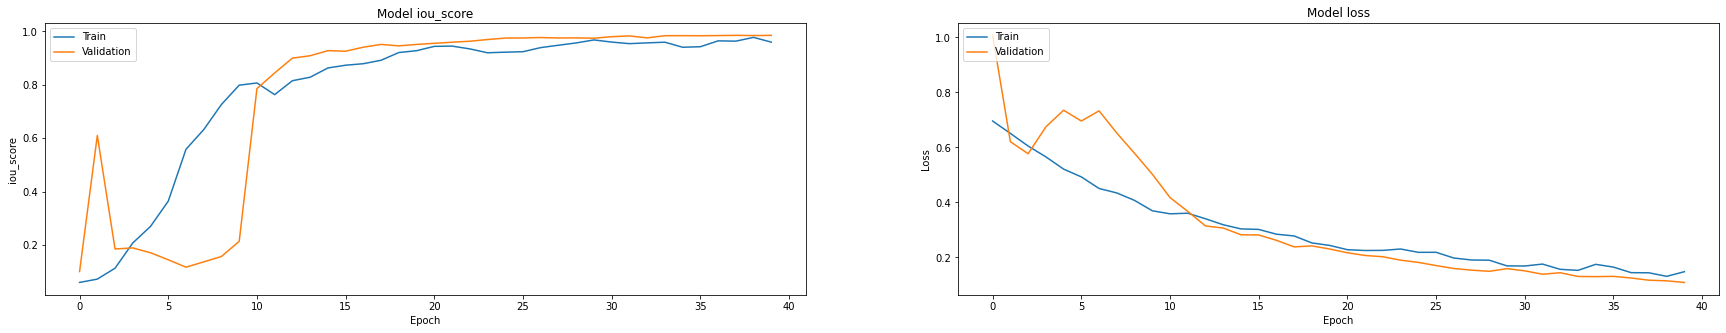

In [82]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Model Evaluation

In [83]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

In [69]:
def loss_fn():
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)
  return total_loss
def IOUScore():
  return sm.metrics.IOUScore(threshold=0.5)
def f1_fn():
  return sm.metrics.FScore(threshold=0.5)
# model2 = KerasRegressor(build_fn=model_build_fn, epochs=10, batch_size=10, verbose=1)
model = keras.models.load_model('model_v9_128.h5',custom_objects={'dice_loss_plus_1binary_focal_loss':loss_fn,'iou_score':IOUScore,'f1-score':f1_fn})


In [84]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

16/16 [==============================] - 31s 2s/step - loss: 0.1040 - iou_score: 0.9879 - f1-score: 0.9939
Loss: 0.10396
mean iou_score: 0.9879
mean f1-score: 0.99386


##Visualization of results on test dataset

1/1 [==============================] - 0s 159ms/step
(1, 3072, 4096, 1)
(3072, 4096)


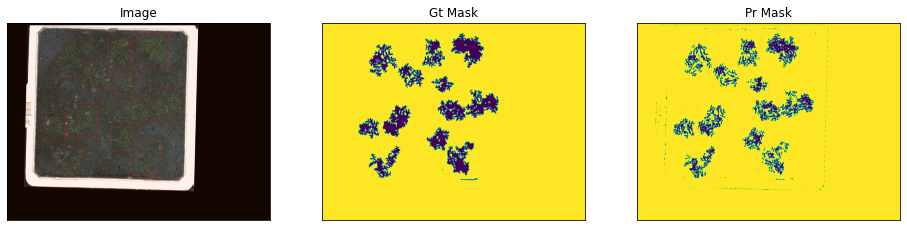

1/1 [==============================] - 0s 156ms/step
(1, 3072, 4096, 1)
(3072, 4096)


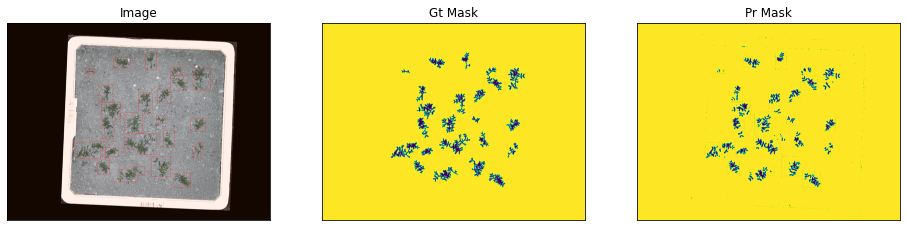

1/1 [==============================] - 0s 155ms/step
(1, 3072, 4096, 1)
(3072, 4096)


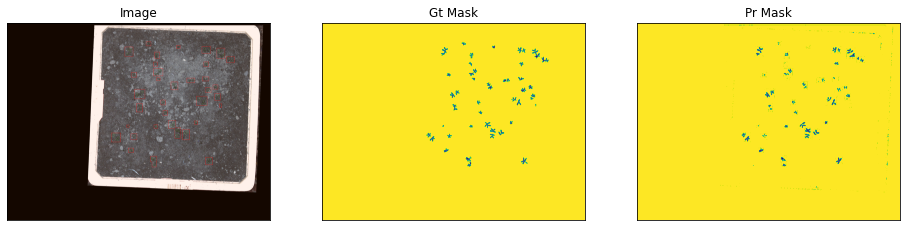

1/1 [==============================] - 0s 169ms/step
(1, 3072, 4096, 1)
(3072, 4096)


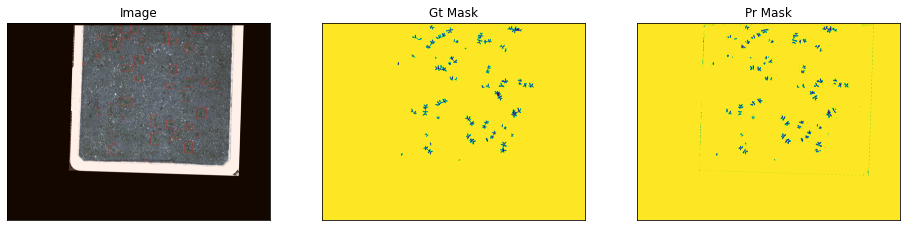

1/1 [==============================] - 0s 158ms/step
(1, 3072, 4096, 1)
(3072, 4096)


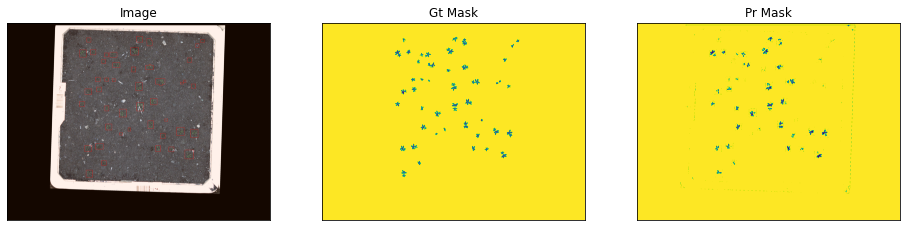

1/1 [==============================] - 0s 155ms/step
(1, 3072, 4096, 1)
(3072, 4096)


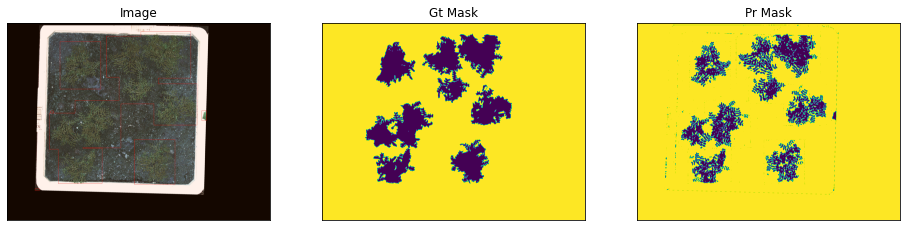

1/1 [==============================] - 0s 157ms/step
(1, 3072, 4096, 1)
(3072, 4096)


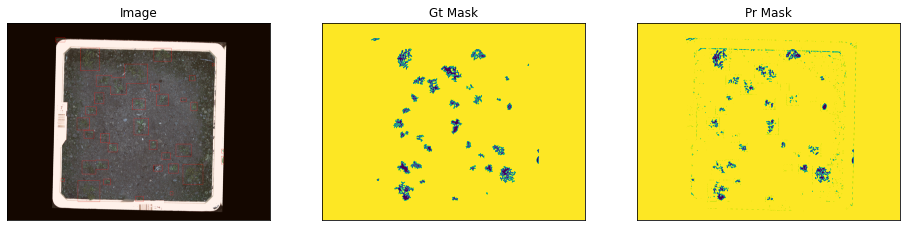

1/1 [==============================] - 0s 168ms/step
(1, 3072, 4096, 1)
(3072, 4096)


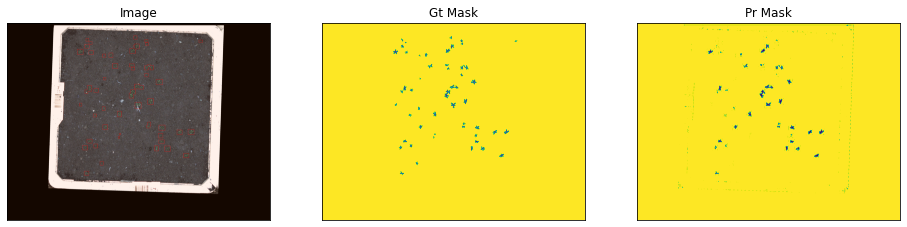

1/1 [==============================] - 0s 160ms/step
(1, 3072, 4096, 1)
(3072, 4096)


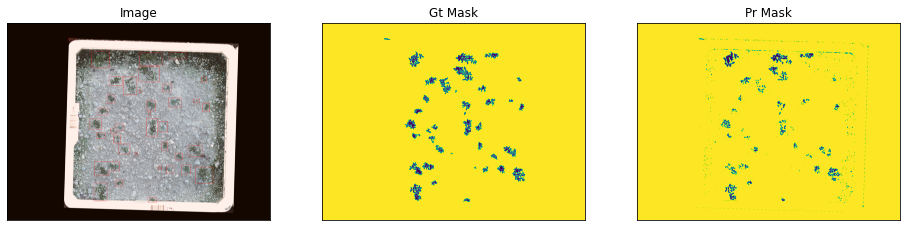

1/1 [==============================] - 0s 158ms/step
(1, 3072, 4096, 1)
(3072, 4096)


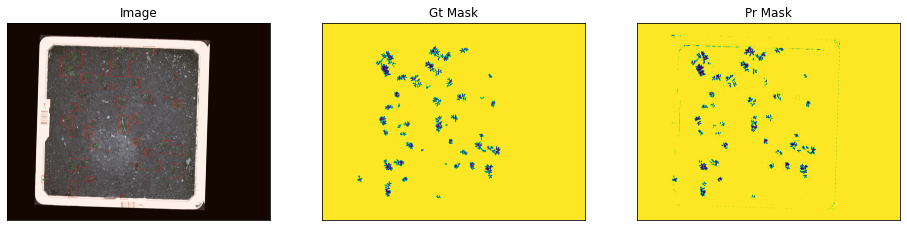

1/1 [==============================] - 0s 168ms/step
(1, 3072, 4096, 1)
(3072, 4096)


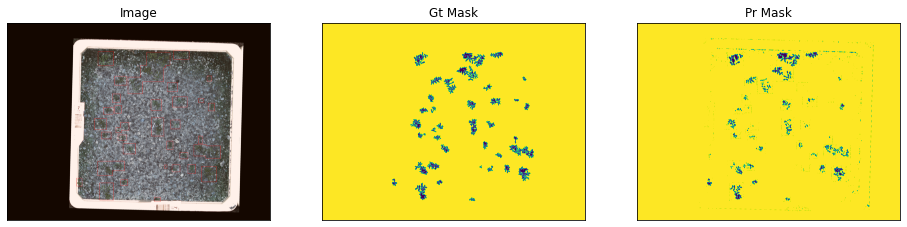

1/1 [==============================] - 0s 166ms/step
(1, 3072, 4096, 1)
(3072, 4096)


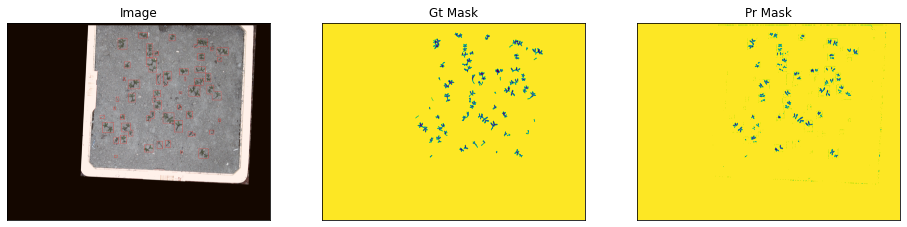

1/1 [==============================] - 0s 168ms/step
(1, 3072, 4096, 1)
(3072, 4096)


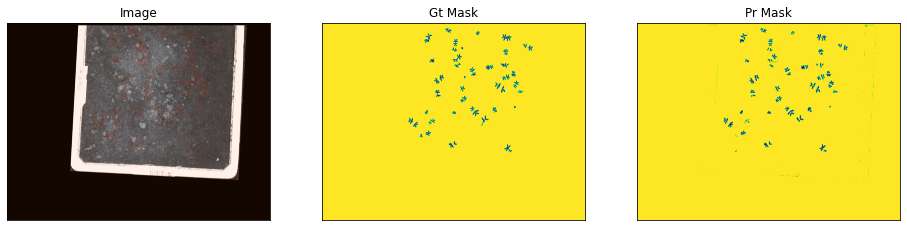

1/1 [==============================] - 0s 234ms/step
(1, 3072, 4096, 1)
(3072, 4096)


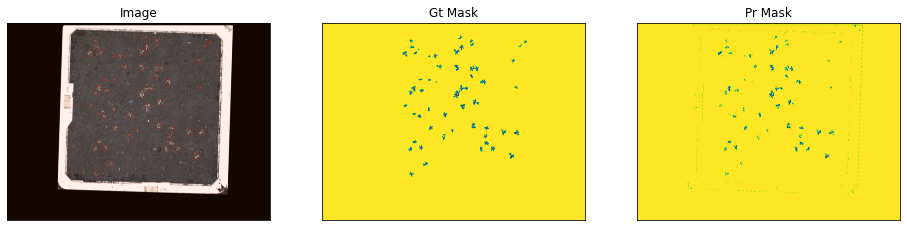

1/1 [==============================] - 0s 168ms/step
(1, 3072, 4096, 1)
(3072, 4096)


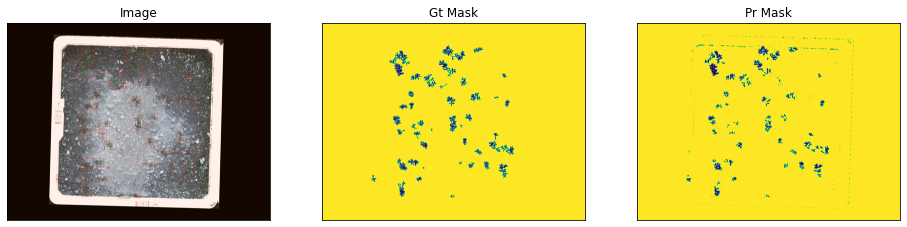

In [102]:
from PIL import Image

n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
for i in range(len(test_dataset)-1):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    print(pr_mask.shape)
    pr_mask = cv2.morphologyEx(pr_mask[..., 0].squeeze(), cv2.MORPH_OPEN, kernel)
    print(pr_mask.shape)
    # im = Image.fromarray(pr_mask)
    # im.save(f'{i}.png')
 
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask,
    )

###Test Model

In [88]:
aug = A.PadIfNeeded(min_height=1088, min_width=1920, p=1,border_mode=cv2.BORDER_CONSTANT)

input : (1080, 1920, 3)
add padding : (1088, 1920, 3)
1/1 [==============================] - 0s 24ms/step


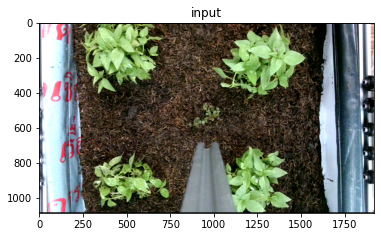

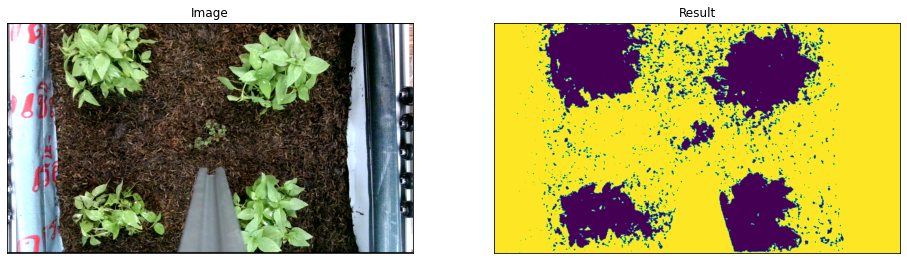

In [109]:
image = cv2.imread('/content/RWSIP (2).png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

augmented = aug(image=image)
image_padded = augmented['image']
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(13,13))
print(f'input : {image.shape}')
print(f'add padding : {image_padded.shape}')

plt.title('input')
plt.imshow(image)

image_padded = np.expand_dims(image_padded, axis=0)
result = model.predict(image_padded).round()[..., 0].squeeze()
# result = cv2.morphologyEx(result[..., 0].squeeze(), cv2.MORPH_OPEN, kernel)
plt.imshow(image_padded[0])
visualize(
    image=denormalize(image_padded.squeeze()),
    result = result,
    )